In [83]:
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats

In [84]:
dt = 0.01
time_horizon = 100
num_steps = int(time_horizon/dt)
num_trajectories = 1000
noise = random.normal(loc=0.0, scale=dt**(1/2), size=(num_trajectories, num_steps))

In [85]:
shallow = False

x_init = 1 if shallow else -1
well_depth = 1.17 if shallow else 4.29

jump_mult = 2.78
t = np.linspace(0, time_horizon, num_steps)
epsilon = (well_depth * 2 / np.log(time_horizon)) * jump_mult

In [86]:
def const_neg_potential(x, t, period=100):
    """Defines the potential function."""
    t = 25
    a1 = 0
    a2 = -3.2
    a3 = 3 * np.sin(2 * np.pi * t / period)
    a6 = 1
    a4 = (-3 / 2) * a6 + (8 / 5)
    a5 = -(3 / 5) * a3
    all_scale = 1.3

    # Clip x to prevent overflow
    x_clipped = np.clip(x, -1e2, 1e2)  # Adjust bounds as needed

    return all_scale * (a6 * 6 * x_clipped**5 + a5 * 5 * x_clipped**4 + 
                        a4 * 4 * x_clipped**3 + a3 * 3 * x_clipped**2 + 
                        a2 * 2 * x_clipped + a1)

def mu(x, t):
    return -const_neg_potential(x, t)

def sigma(x, t):
    return epsilon ** (1/2)

In [87]:
def simulate(x_init, dt, num_trajectories, num_steps, time_vec, noise, jump_threshold=1, delta=1):
    jump_times = np.empty((num_trajectories,))
    # Store multiple trajectories
    trajectories = np.zeros((num_trajectories, num_steps))
    
    for j in tqdm(range(num_trajectories)):
        x = np.zeros((num_steps,))
        x[0] = x_init
        jump_detected = False
        steps_since_jump = 0
        potential_jump_time = None
        
        for i in range(num_steps - 1):
            curr_t = time_vec[i]
            curr_x = x[i]
            dW = noise[j, i]
            
            x[i+1] = (curr_x + 
                      mu(curr_x, curr_t) * dt + 
                      sigma(curr_x, curr_t) * dW)
            
            # Check if trajectory crosses the jump threshold
            if not jump_detected:
                if x[i+1] >= jump_threshold:
                    jump_detected = True
                    steps_since_jump = 0
                    potential_jump_time = curr_t
            
            # If jump is detected, monitor persistence
            elif steps_since_jump < delta:
                steps_since_jump += 1
                
                # If trajectory falls back below threshold, reset jump detection
                if x[i+1] < jump_threshold:
                    jump_detected = False
                    steps_since_jump = 0
                    potential_jump_time = None
                
                # If trajectory remains above threshold for delta steps
                if steps_since_jump == delta:
                    jump_times[j] = potential_jump_time
                    break
        
        # Store the complete trajectory for this iteration
        trajectories[j] = x
        
        # If we reach the end without confirming a jump
        if not jump_detected or steps_since_jump < delta:
            jump_times[j] = np.nan
    
    # Return the trajectories along with jump times
    return trajectories, jump_times

In [88]:
def simulate(x_init, dt, num_trajectories, num_steps, time_vec, noise, jump_threshold=1, delta=12):
    jump_times = np.empty((num_trajectories,))
    trajectories = np.zeros((num_trajectories, num_steps))
    
    for j in tqdm(range(num_trajectories)):
        x = np.zeros((num_steps,))
        x[0] = x_init
        steps_above_threshold = 0
        jump_confirmed = False
        first_cross_index = None
        
        for i in range(num_steps - 1):
            curr_x = x[i]
            dW = noise[j, i]
            
            # Update trajectory
            x[i+1] = curr_x + mu(curr_x, time_vec[i]) * dt + sigma(curr_x, time_vec[i]) * dW
            
            # Check if above jump_threshold
            if x[i+1] >= jump_threshold:
                steps_above_threshold += 1
                if steps_above_threshold == 1:
                    first_cross_index = i + 1  # Index where threshold was first crossed
            else:
                steps_above_threshold = 0
                first_cross_index = None
            
            # Check if persistence criteria met
            if steps_above_threshold >= delta:
                # Backtrack to find last crossing from <0 to >=0 before first_cross_index
                last_zero_cross = None
                if first_cross_index is not None:
                    for k in range(first_cross_index, 0, -1):
                        if x[k] >= 0 and x[k-1] < 0:
                            last_zero_cross = time_vec[k]
                            break
                jump_times[j] = last_zero_cross if last_zero_cross is not None else np.nan
                jump_confirmed = True
                break
        
        if not jump_confirmed:
            jump_times[j] = np.nan
        
        trajectories[j] = x
    
    return trajectories, jump_times

In [89]:
trajectories, jump_times = simulate(x_init, dt, num_trajectories, num_steps, t, noise)
data = jump_times.copy()

100%|██████████| 1000/1000 [00:02<00:00, 359.41it/s]


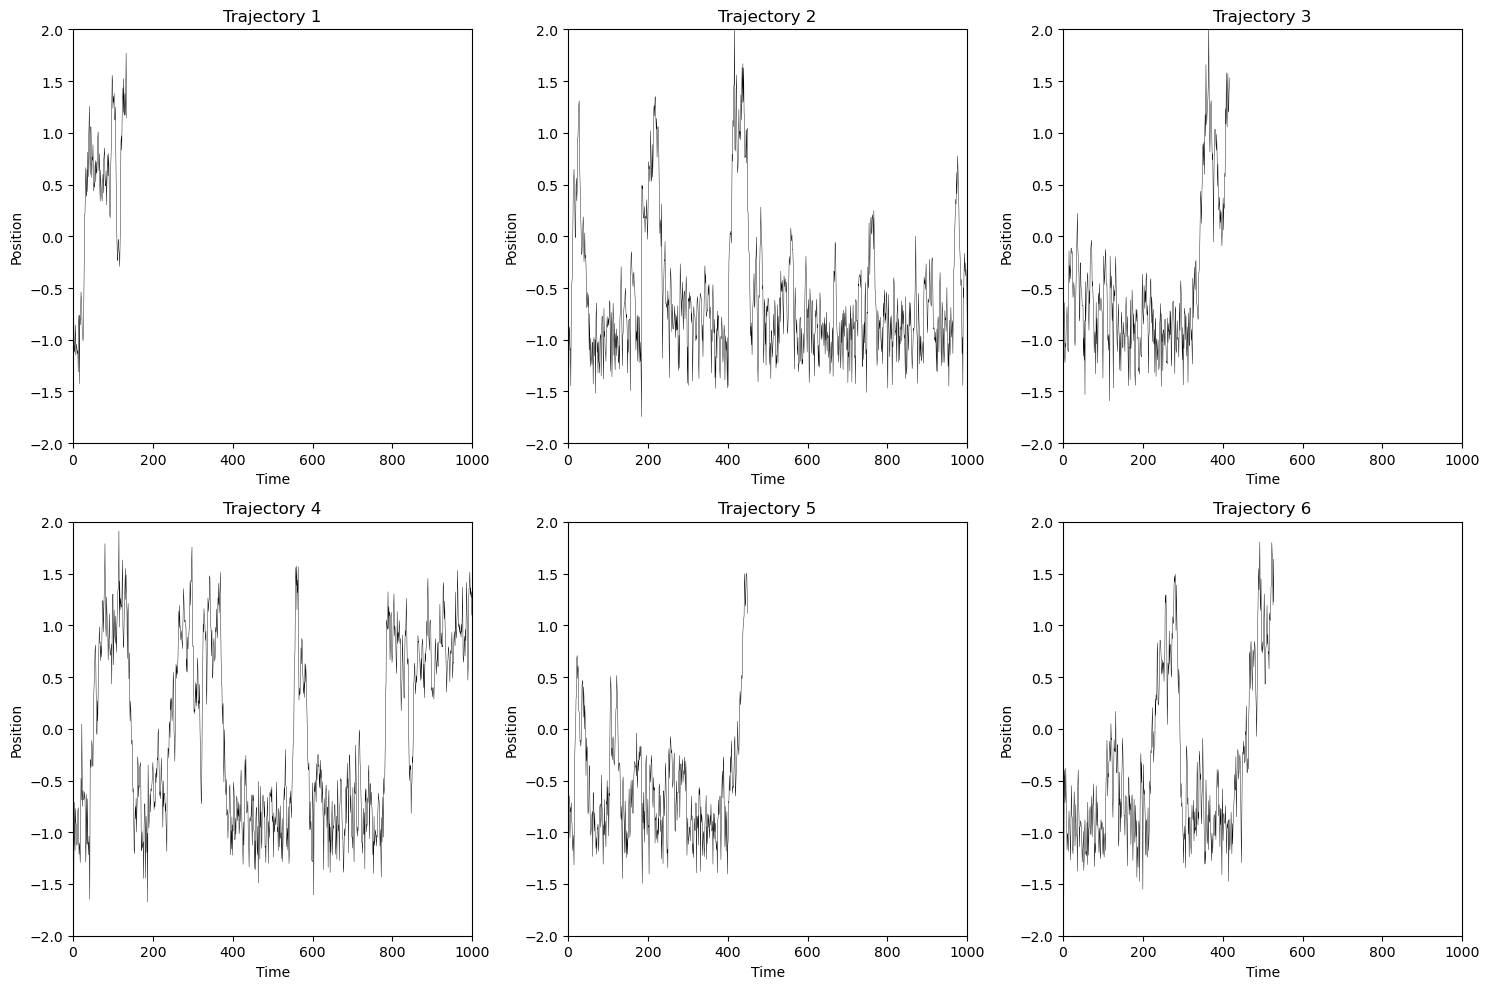

In [90]:
traj = trajectories[:6]

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the 2D array of axes for easier iteration
axs = axs.flatten()

# Plot each trajectory in its own subplot
for i in range(6):
    new_traj = traj[i][traj[i] != 0]
    axs[i].plot(new_traj, color='black', linewidth=0.3)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Position')
    # keep x-axis the same throughout plots
    axs[i].set_xlim(0, 1000)
    axs[i].set_ylim(-2, 2)
    axs[i].set_title(f'Trajectory {i+1}')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

In [91]:
data = jump_times.copy()
data[np.isnan(data)] = time_horizon
data

array([ 1.19011901, 13.51135114,  3.99039904,  8.53085309,  4.30043004,
        4.86048605, 14.88148815,  1.58015802,  3.53035304,  2.25022502,
        2.11021102,  1.37013701, 13.18131813,  6.98069807,  2.48024802,
        1.28012801,  0.54005401,  8.14081408,  2.17021702, 14.29142914,
        3.35033503, 13.79137914,  7.63076308,  1.25012501, 14.73147315,
        6.29062906,  0.54005401, 14.04140414,  8.56085609,  2.57025703,
        2.43024302,  7.57075708,  5.23052305,  3.09030903,  2.85028503,
        7.40074007,  7.90079008,  4.92049205,  9.7109711 ,  2.25022502,
        0.230023  ,  4.90049005, 17.20172017, 12.92129213,  3.83038304,
        6.37063706,  2.81028103,  7.66076608,  9.8909891 ,  1.45014501,
       11.66116612, 11.79117912,  2.15021502,  7.32073207,  6.12061206,
       17.09170917,  3.55035504,  1.46014601,  4.94049405,  2.17021702,
        5.07050705,  0.81008101,  3.79037904,  3.93039304,  0.70007001,
        4.26042604, 15.02150215,  0.63006301, 11.21112111,  7.69

---

In [92]:
theoretical_rate = 1/(np.exp(well_depth * 2/epsilon))
rate = 1/np.mean(data)
print(f"Theoretical rate: {theoretical_rate}, Measured rate: {rate}")

Theoretical rate: 0.19079875633964757, Measured rate: 0.19774743149838325


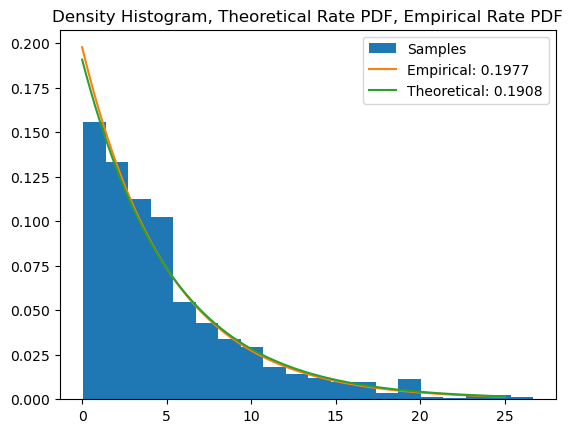

In [93]:
x = np.linspace(0, 25, 100)
y = rate * np.exp(-rate * x)

plt.hist(data, density=True, bins=20, label='Samples')
plt.plot(x, y, label=f'Empirical: {np.round(rate, 4)}')
plt.plot(x, theoretical_rate * np.exp(-theoretical_rate * x), label=f'Theoretical: {np.round(theoretical_rate, 4)}')
plt.title('Density Histogram, Theoretical Rate PDF, Empirical Rate PDF')
plt.legend()
plt.show()

In [94]:
def exp_cdf(x, rate=theoretical_rate):
    return 1 - np.exp(-rate * x)

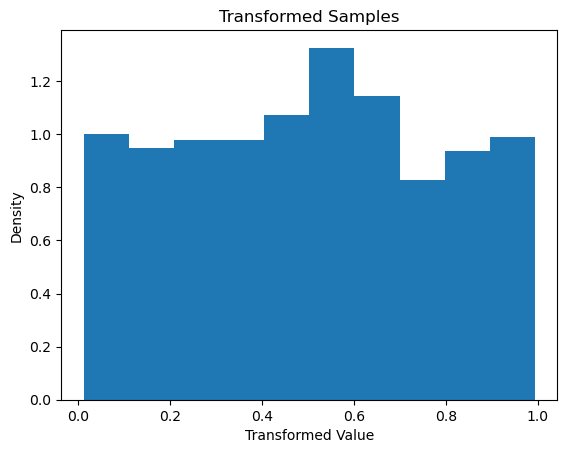

In [95]:
x_uniformed = exp_cdf(data)
plt.hist(x_uniformed, density=True, label='Transformed Samples')
plt.title('Transformed Samples')
plt.ylabel('Density')
plt.xlabel('Transformed Value')
plt.show()

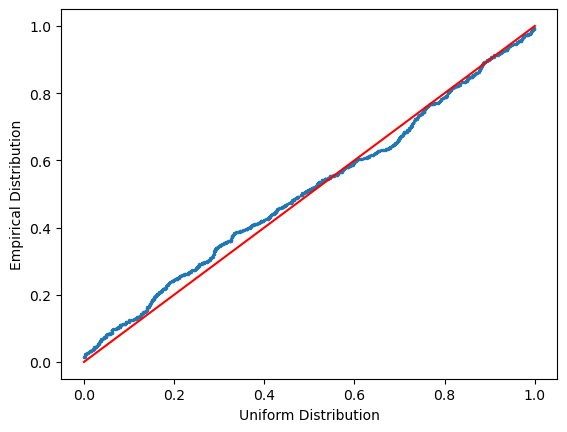

In [96]:
uniform = np.random.uniform(0, 1, len(data))
uniform_sort = np.sort(uniform)

plt.scatter(uniform_sort, np.sort(x_uniformed), s=2)
plt.xlabel('Uniform Distribution')
plt.ylabel('Empirical Distribution')
plt.plot([0,1],[0,1], color='red')
plt.savefig(f'qq_deep_to_shallow.svg', transparent=True)
plt.show()

In [97]:
stats.anderson(data, dist='expon')

AndersonResult(statistic=2.7309499862698203, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0, scale=5.056955695569557)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [98]:
stats.cramervonmises(x_uniformed, 'uniform')

CramerVonMisesResult(statistic=0.33741257327795227, pvalue=0.10640290093072335)

In [99]:
obs_counts, bin_edges = np.histogram(x_uniformed, bins=20)

total_count = obs_counts.sum()
num_categories = obs_counts.size

expected = np.full(num_categories, total_count / num_categories)

stats.chisquare(f_obs=obs_counts, f_exp=expected)

Power_divergenceResult(statistic=31.119999999999997, pvalue=0.03916525899352111)